<h1 align='center'>Data Science Analysis</h1>
<h1 align='center'>Assignment 7</h1>
<h2 align='center'>Pushkal Mishra</h2>
<h2 align='center'>EE20BTECH11042</h2>

# Importing Libraries

In [1]:
import emcee
import corner
import nestle
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Question 1

We have to fit the linear funciton on the given data as:
$$ 
    f_{gas} = f_{0} (1 + f_{1} z) 
$$

with the bounds on $f_{0}$ and $f_{1}$ as
$$  
    0 < f_{0} < 0.5 \\
    -0.5 < f_{1} < 0.5
$$

In [2]:
# Functions from JVDPs blog on performing Bayesian analysis
def log_prior(theta):
    f0, f1 = theta
    if (f0 > 0 and f0 < 0.5) and (f1 > -0.5 and f1 < 0.5):
        return 0
    else:
        return -np.inf
    
def log_likelihood(theta, x, y, sigma_y):
    f0, f1 = theta
    y_model = f0 * (1 + f1 * x)
    del_chi2 = np.sum(np.log(2 * np.pi * sigma_y ** 2) + ((y - y_model) / sigma_y) ** 2)
    return -0.5 * del_chi2

def neg_log_likelihood(theta, x, y, sigma_y):
    return -log_likelihood(theta, x, y, sigma_y)

def log_posterior(theta, x, y, sigma_y):
    log_pr = log_prior(theta)
    if np.isfinite(log_pr):
        return log_pr + log_likelihood(theta, x, y, sigma_y)
    return -np.inf

In [3]:
q1_data = np.loadtxt("q1_data.csv", delimiter = " ", dtype = str)

z = []
f_gas = []
f_err = []

for data in q1_data:
    z.append(float(data[0]))
    f_gas.append(float(data[1]))
    f_err.append(float(data[2]))
    
z = np.array(z)
f_gas = np.array(f_gas)
f_err = np.array(f_err)

optim_solution = optimize.fmin(func = neg_log_likelihood, x0 = [0.0, 0.0], args = (z, f_gas, f_err))

n_params = 2
n_walkers = 100  
n_burn = 1000  
n_steps = 5000

np.random.seed(11042)

initial_guesses = optim_solution + 1e-3 * np.random.random([n_walkers, n_params])
mcmc_sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args = [z, f_gas, f_err])

dump = mcmc_sampler.run_mcmc(initial_guesses, n_steps, progress = True)
mcmc_samples = mcmc_sampler.get_chain(discard = n_burn, flat = True)

Optimization terminated successfully.
         Current function value: -200.732529
         Iterations: 63
         Function evaluations: 120


100%|████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 419.32it/s]


Estimated parameter values for best fit are:
f0 = 0.1182968820994239
f1 = -0.07434616099756106


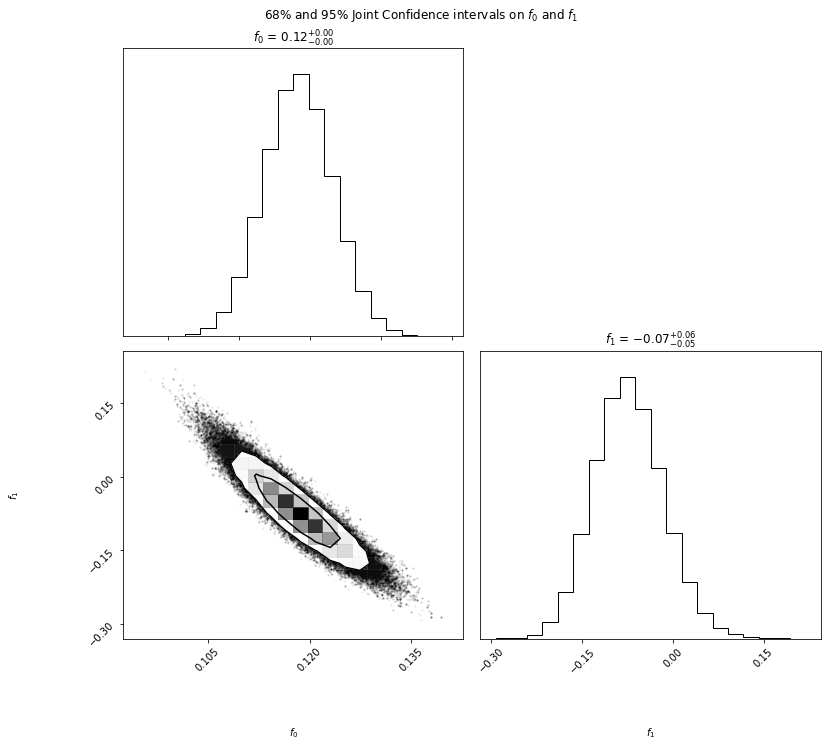

In [4]:
f0_median, f1_median = np.median(mcmc_samples, axis = 0)
print("Estimated parameter values for best fit are:")
print(f"f0 = {f0_median}")
print(f"f1 = {f1_median}")

fig = plt.figure(figsize = (13, 11))
figure = corner.corner(mcmc_samples, levels = [0.68, 0.90], labels = [r"$f_0$", r"$f_1$"], fig = fig, show_titles = True)
plt.suptitle("68% and 95% Joint Confidence intervals on" + r" $f_0$ " + "and" + " $f_1$")
plt.show()

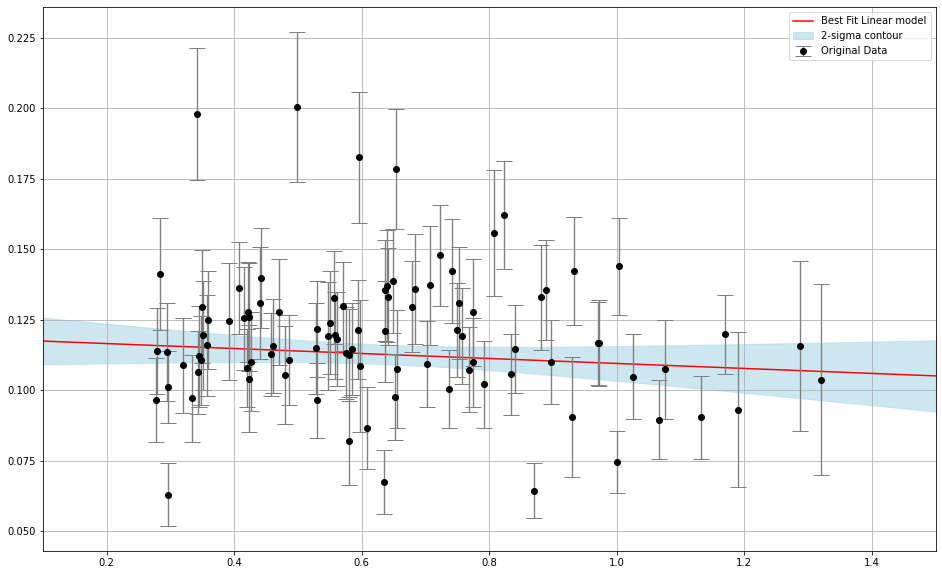

In [5]:
f0, f1 = mcmc_samples.T[ : 2]
x_plot = np.linspace(0.1, 1.5, 300)
y_plot = f0[: , None] * (1 + f1[: , None] * x_plot)
mu = y_plot.mean(0)
sigma = 2 * y_plot.std(0)

plt.figure(figsize = (16, 10))
plt.plot(x_plot, mu, color = "red", label = "Best Fit Linear model")
plt.fill_between(x_plot, mu - sigma, mu + sigma, color = 'lightblue', alpha = 0.6, label = "2-sigma contour")
plt.errorbar(z, f_gas, f_err, fmt = "ok", lw = 1.35, capsize = 8, ecolor = "gray", label = "Original Data")
plt.xlim(0.1, 1.5)
plt.legend()
plt.grid()
plt.show()

# Question 2

In [6]:
q2_data = np.array([[ 0.42, 0.72, 0.0 ,  0.3 ,  0.15,
                   0.09, 0.19, 0.35,  0.4 ,  0.54,
                   0.42, 0.69, 0.2 ,  0.88,  0.03,
                   0.67, 0.42, 0.56,  0.14,  0.2 ],
                 [ 0.33, 0.41, -0.22, 0.01, -0.05, 
                  -0.05, -0.12, 0.26, 0.29,  0.39, 
                   0.31, 0.42, -0.01, 0.58, -0.2,
                   0.52, 0.15, 0.32, -0.13, -0.09 ],
                 [ 0.1,  0.1,  0.1,   0.1,   0.1, 
                   0.1,  0.1,  0.1,   0.1,   0.1, 
                   0.1,  0.1,  0.1,   0.1,   0.1,
                   0.1,  0.1,  0.1,   0.1,   0.1 ]])

def polynomial_fit(theta, x):
    return sum(t * x ** n for (n, t) in enumerate(theta))

def log_prior(theta):
    return 200 * theta - 100

def log_likelihood(theta, data = q2_data):
    x, y, sigma_y = data
    y_pred = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2) + (y - y_pred) ** 2 / sigma_y ** 2)

In [7]:
np.random.seed(11042)

linear_fit = nestle.sample(log_likelihood, log_prior, 2)
print("Summary of Linear Fit:")
print(linear_fit.summary())
print(f"\nThe Log-Evidence for Linear Model: {linear_fit.logz}\n")

quadratic_fit = nestle.sample(log_likelihood, log_prior, 3)
print("Summary of Quadratic Fit:")
print(quadratic_fit.summary())
print(f"\nThe Log-Evidence for Quadratic Model: {quadratic_fit.logz}")

print(f"\nFrom the fifth blog article of the Pythonic Perambulations Series, the Log-Evidence values were:")
print("For Linear Model: 46942613.34886921")
print("For Quadratic Model: 111116773.89368105")

Summary of Linear Fit:
niter: 1618
ncall: 2772
nsamples: 1718
logz:  6.683 +/-  0.378
h: 14.285

The Log-Evidence for Linear Model: 6.683109087857267

Summary of Quadratic Fit:
niter: 2167
ncall: 3989
nsamples: 2267
logz:  2.080 +/-  0.440
h: 19.388

The Log-Evidence for Quadratic Model: 2.0795724779962583

From the fifth blog article of the Pythonic Perambulations Series, the Log-Evidence values were:
For Linear Model: 46942613.34886921
For Quadratic Model: 111116773.89368105


##### Clearly these values do not match with the ones obtained from the Nested sampling by Nestle.

# Question 3

In [8]:
q3_data = pd.read_csv('q3_data.txt', sep = '\s+')

z = q3_data['z'].to_numpy().reshape([-1, 1])
x = np.linspace(-0.5, 5.5, 6000).reshape([-1, 1])

kde_gauss = KernelDensity(kernel = 'gaussian', bandwidth = 0.2).fit(z)
log_density_gauss = np.exp(kde_gauss.score_samples(x))

kde_exp = KernelDensity(kernel = 'exponential', bandwidth = 0.2).fit(z)
log_density_exp = np.exp(kde_exp.score_samples(x))

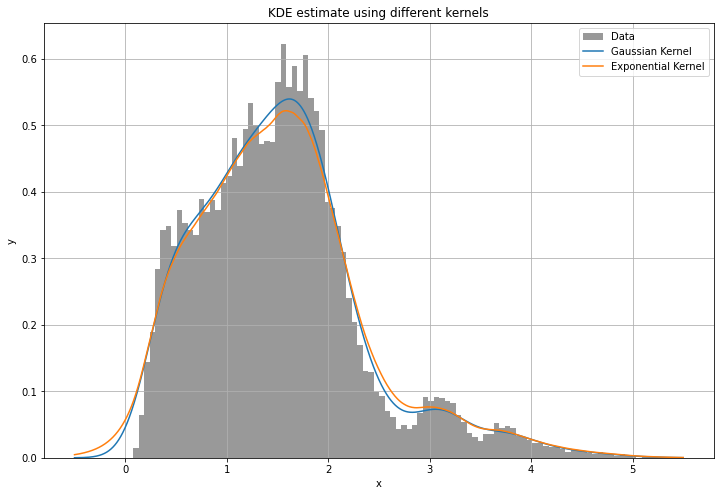

In [9]:
fig = plt.figure(figsize = (12, 8))
plt.hist(z, bins = "auto", density = True, color = "black", alpha = 0.4, label = "Data")
plt.plot(x, log_density_gauss, label = "Gaussian Kernel")
plt.plot(x, log_density_exp, label = "Exponential Kernel")
plt.title("KDE estimate using different kernels")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()